### Imports

In [1]:
! pip install unidecode
! pip install transformers
! pip install torch
! pip install spacy
! pip install pandas
! pip install gensim
! pip install xgboost
! pip install gensim
! pip install scikit-learn
! pip install unidecode
! pip install torch.utils.data
! pip install seaborn
! pip install matplotlib

import pandas as pd
import re
import spacy
import string
import numpy as np
import nltk
import torch
import sklearn
import matplotlib.pyplot as plt
import seaborn
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from unidecode import unidecode
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 12.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer('english')
STOP_WORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Dataset

In [3]:
df = pd.read_csv('sample_data/racism-dataset.csv', sep=',', index_col=0)
df.head(10)

,label,text
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before the...
7,0,@user camping tomorrow @user @user @user @use...
8,0,the next school year is the year for exams.ð...
9,0,we won!!! love the land!!! #allin #cavs #champ...
10,0,@user @user welcome here ! i'm it's so #gr8 !


In [4]:
MAX_PREDOMINANT_LABEL_SAMPLES = 10000

dfNonHate = df[df["label"] == 0].head(MAX_PREDOMINANT_LABEL_SAMPLES)
dfHate = df[df["label"] == 1]

df = pd.concat([dfNonHate, dfHate])

### Train & test splits

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.4, random_state=42)

print('train data length:', len(X_train))
print('test data length:', len(X_test))

train data length: 7345
test data length: 4897


In [6]:
dfTrainTfidf = pd.DataFrame(list(zip(X_train, y_train)), columns =['text', 'label'])
dfTrainTfidf.head()

dfTrainCbow = pd.DataFrame(list(zip(X_train, y_train)), columns =['text', 'label'])
dfTrainCbow.head()

,text,label
0,keeping to my happiness goals for the month - ...,0
1,@user as a huge @user fan i'm excited for liv...,0
2,ððlove girlsðð #bihday #yuiko#pa...,0
3,"this much #hatred, #xenophobia, #islamophobia,...",1
4,@user can't wait... excited to watch lemans th...,0


In [7]:
dfTestTfidf = pd.DataFrame(list(zip(X_test, y_test)), columns =['text', 'label'])
dfTestTfidf.head()

dfTestCbow = pd.DataFrame(list(zip(X_test, y_test)), columns =['text', 'label'])
dfTestCbow.head()

,text,label
0,i worked to had for this #highschoolgraduation...,0
1,so proud to have a mayor like @user who isnt a...,1
2,#bihday #shout #out to my broda @user smile ...,0
3,i am wholesome. #i_am #positive #affirmation,0
4,#nazi #swastika #ebay! #trump #donaldtrump #re...,1


### Preprocessing

In [8]:
def apply(df, functions):
    for f in functions:
        df = df.apply(f)
    return df

def removeHyperlinks(text):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

def removeHandles(text):
    return re.sub(r'@[\w]*', ' ', text)

def removeHashtags(text):
    return re.sub(r'#', ' ', text)

def removeHashtagsAndWords(text):
    return re.sub(r'#[\w]*', ' ', text)

def removeRepeating(text):
    return re.sub(r'([a-zA-Z])\1{2,}', r'\1', text)

def removeWhitespaces(text):
    return re.sub(r'\s+', ' ', text)

def removeDigits(text):
    return re.sub(r'\d+', '', text)

def unidecodeLowercase(text):
    return unidecode(text.lower())

def removePunctuation(text):
    return "".join(c if c not in string.punctuation else ' ' for c in text)

def removeStopwords(text):
    return " ".join([w for w in text.split() if w.lower() not in STOP_WORDS and len(w) > 2])

def stem(text):
    return " ".join([stemmer.stem(token) for token in text.split()])

def lemma(text):
    return " ".join([w.lemma_ for w in nlp(text)])

In [9]:
tfIdf_preprocessing = [
    unidecodeLowercase,
    removeHyperlinks,
    removeHandles,
    removeHashtags,
    removePunctuation,
    removeDigits,
    removeRepeating,
    lemma,
    removeStopwords,
    removeWhitespaces
]

cbow_preprocessing = [
    unidecodeLowercase,
    removeHyperlinks,
    removeHandles,
    removeHashtagsAndWords,
    removePunctuation,
    removeDigits,
    removeRepeating,
    lemma,
    removeStopwords,
    removeWhitespaces
]

In [10]:
dfTrainTfidf['clean'] = apply(dfTrainTfidf['text'], tfIdf_preprocessing)
dfTrainTfidf['tokens'] = [text.split() for text in dfTrainTfidf['clean'].tolist()]

dfTrainTfidf.head(10)

,text,label,clean,tokens
0,keeping to my happiness goals for the month - ...,0,keep happiness goal month outside get fresh ai...,"[keep, happiness, goal, month, outside, get, f..."
1,@user as a huge @user fan i'm excited for liv...,0,huge fan excited live stream amp midday via gi...,"[huge, fan, excited, live, stream, amp, midday..."
2,ððlove girlsðð #bihday #yuiko#pa...,0,ddlove girlsdd bihday yuiko paya,"[ddlove, girlsdd, bihday, yuiko, paya]"
3,"this much #hatred, #xenophobia, #islamophobia,...",1,much hatred xenophobia islamophobia antisemiti...,"[much, hatred, xenophobia, islamophobia, antis..."
4,@user can't wait... excited to watch lemans th...,0,wait excited watch leman year lemans lemans le...,"[wait, excited, watch, leman, year, lemans, le..."
5,lol i just feel and #useless,0,lol feel useless,"[lol, feel, useless]"
6,is defunding aboion and sending you to the #...,1,defunde aboion send inauguration,"[defunde, aboion, send, inauguration]"
7,there are ceain happenings in our lives that w...,0,ceain happening life woh like agree life,"[ceain, happening, life, woh, like, agree, life]"
8,train tickets booked for my opera week in wales,0,train ticket book opera week wale,"[train, ticket, book, opera, week, wale]"
9,#e3 just isn't the same without @user @user @u...,0,without cover together gwaslife missyouguy,"[without, cover, together, gwaslife, missyouguy]"


In [11]:
dfTestTfidf['clean'] = apply(dfTestTfidf['text'], tfIdf_preprocessing)
dfTestTfidf['tokens'] = [text.split() for text in dfTestTfidf['clean'].tolist()]

dfTestTfidf.head(10)

,text,label,clean,tokens
0,i worked to had for this #highschoolgraduation...,0,work highschoolgraduation classof diploma,"[work, highschoolgraduation, classof, diploma]"
1,so proud to have a mayor like @user who isnt a...,1,proud mayor like afraid speak truth yes comple...,"[proud, mayor, like, afraid, speak, truth, yes..."
2,#bihday #shout #out to my broda @user smile ...,0,bihday shout broda smile shine like star whilea,"[bihday, shout, broda, smile, shine, like, sta..."
3,i am wholesome. #i_am #positive #affirmation,0,wholesome positive affirmation,"[wholesome, positive, affirmation]"
4,#nazi #swastika #ebay! #trump #donaldtrump #re...,1,nazi swastika ebay trump donaldtrump republic ...,"[nazi, swastika, ebay, trump, donaldtrump, rep..."
5,"@user disgusting racist thugs, look forward to...",1,disgust racist thug look forward back jail,"[disgust, racist, thug, look, forward, back, j..."
6,boummmmm cleveland ð #teamlebron #clevelan...,0,boum cleveland teamlebron cleveland nba basket...,"[boum, cleveland, teamlebron, cleveland, nba, ..."
7,fathers day to mine and all! #thankspop,0,father day mine thankspop,"[father, day, mine, thankspop]"
8,"@user with all,due respect he was m.m.a.#lege...",0,due respect legend rip kimbo loss,"[due, respect, legend, rip, kimbo, loss]"
9,"@user it's laughable to see all these ""celebri...",0,laughable see celebrity ali funeral funeral se...,"[laughable, see, celebrity, ali, funeral, fune..."


In [12]:
dfTrainCbow['clean'] = apply(dfTrainCbow['text'], cbow_preprocessing)
dfTrainCbow['tokens'] = [text.split() for text in dfTrainCbow['clean'].tolist()]

dfTrainCbow.head(10)

,text,label,clean,tokens
0,keeping to my happiness goals for the month - ...,0,keep happiness goal month outside get fresh ai...,"[keep, happiness, goal, month, outside, get, f..."
1,@user as a huge @user fan i'm excited for liv...,0,huge fan excited live stream amp midday via,"[huge, fan, excited, live, stream, amp, midday..."
2,ððlove girlsðð #bihday #yuiko#pa...,0,ddlove girlsdd,"[ddlove, girlsdd]"
3,"this much #hatred, #xenophobia, #islamophobia,...",1,much much let hope get less,"[much, much, let, hope, get, less]"
4,@user can't wait... excited to watch lemans th...,0,wait excited watch leman year,"[wait, excited, watch, leman, year]"
5,lol i just feel and #useless,0,lol feel,"[lol, feel]"
6,is defunding aboion and sending you to the #...,1,defunde aboion send,"[defunde, aboion, send]"
7,there are ceain happenings in our lives that w...,0,ceain happening life woh like agree,"[ceain, happening, life, woh, like, agree]"
8,train tickets booked for my opera week in wales,0,train ticket book opera week wale,"[train, ticket, book, opera, week, wale]"
9,#e3 just isn't the same without @user @user @u...,0,without cover together,"[without, cover, together]"


In [13]:
dfTestCbow['clean'] = apply(dfTestCbow['text'], cbow_preprocessing)
dfTestCbow['tokens'] = [text.split() for text in dfTestCbow['clean'].tolist()]

dfTestCbow.head(10)

,text,label,clean,tokens
0,i worked to had for this #highschoolgraduation...,0,work,[work]
1,so proud to have a mayor like @user who isnt a...,1,proud mayor like afraid speak truth yes comple...,"[proud, mayor, like, afraid, speak, truth, yes..."
2,#bihday #shout #out to my broda @user smile ...,0,broda smile shine like star whilea,"[broda, smile, shine, like, star, whilea]"
3,i am wholesome. #i_am #positive #affirmation,0,wholesome,[wholesome]
4,#nazi #swastika #ebay! #trump #donaldtrump #re...,1,,[]
5,"@user disgusting racist thugs, look forward to...",1,disgust racist thug look forward back jail,"[disgust, racist, thug, look, forward, back, j..."
6,boummmmm cleveland ð #teamlebron #clevelan...,0,boum cleveland,"[boum, cleveland]"
7,fathers day to mine and all! #thankspop,0,father day mine,"[father, day, mine]"
8,"@user with all,due respect he was m.m.a.#lege...",0,due respect rip loss,"[due, respect, rip, loss]"
9,"@user it's laughable to see all these ""celebri...",0,laughable see celebrity ali funeral funeral se...,"[laughable, see, celebrity, ali, funeral, fune..."


### Feature extraction

##### Tf-idf features

In [14]:
tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(2, 8),
    max_features=None,
    analyzer='char',
    binary=True,
    strip_accents='unicode',
)

In [15]:
train_tfidf_features = tfidf.fit_transform(dfTrainTfidf['clean'].tolist())

feature_names = tfidf.get_feature_names_out()
feature_names

array([' a', ' aa', ' aae', ..., 'zzy reci', 'zzy rel', 'zzy rela'],
      dtype=object)

In [16]:
test_tfidf_features = tfidf.transform(dfTestTfidf['clean'].tolist())

##### Cbow features

In [ ]:
cbow = Word2Vec(
    min_count=1,
    vector_size=1000,
    window=5,
    sg=0, # sg = 0 => CBOW
)

In [ ]:
cbow.build_vocab(dfTrainCbow['tokens'].tolist())
cbow.train(dfTrainCbow['tokens'], total_examples=cbow.vector_size, epochs=200)

word2vec_features = cbow.wv

train_features = [
    [cbow.wv[token] if token in cbow.wv else np.zeros(cbow.vector_size) for token in row] 
    if len(row) else [np.zeros(cbow.vector_size)] for row in dfTrainCbow['tokens']]


print(len(train_features))

train_cbow_features = np.array([np.sum(features, axis=0) for features in train_features])
train_cbow_features_normalized = sklearn.preprocessing.MinMaxScaler().fit_transform(train_cbow_features)

7345


In [ ]:
test_features = [
    [cbow.wv[token] if token in cbow.wv else np.zeros(cbow.vector_size) for token in row] 
    if len(row) else [np.zeros(cbow.vector_size)] for row in dfTestCbow['tokens']]

print(len(test_features))

test_cbow_features = np.array([np.sum(features, axis=0) for features in test_features])
test_cbow_features_normalized = sklearn.preprocessing.MinMaxScaler().fit_transform(test_cbow_features)

4897


### Models

In [29]:
def print_confusion_matrix(y_true, y_pred, title):
    title += "    f1: " + "{:.2f}".format(f1_score(y_test, y_pred, average="macro"))
    matrix = confusion_matrix(y_true, y_pred)
    seaborn.heatmap(matrix, annot=True, fmt='g')
    plt.title(title)

##### Multinomial Naive Bayes with Tf-Idf

In [ ]:
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(train_tfidf_features, y_train)

MultinomialNB()

In [ ]:
y_pred = mnb_tfidf.predict(test_tfidf_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      4021
           1       0.99      0.12      0.22       876

    accuracy                           0.84      4897
   macro avg       0.92      0.56      0.57      4897
weighted avg       0.87      0.84      0.79      4897



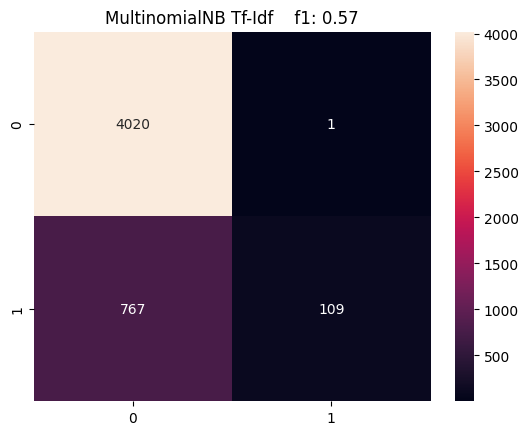

In [ ]:
print_confusion_matrix(y_test, y_pred, "MultinomialNB Tf-Idf")

##### Multinomial Naive Bayes with Normalized CBOW

In [ ]:
mnb_cbow = MultinomialNB()
mnb_cbow.fit(train_cbow_features_normalized, y_train)

MultinomialNB()

In [ ]:
y_pred = mnb_cbow.predict(test_cbow_features_normalized)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      4021
           1       0.64      0.22      0.32       876

    accuracy                           0.84      4897
   macro avg       0.75      0.60      0.62      4897
weighted avg       0.81      0.84      0.80      4897



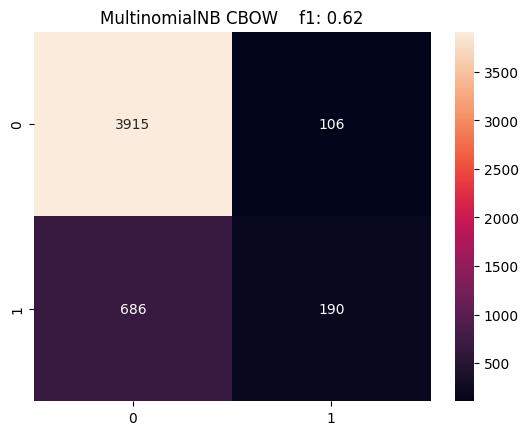

In [ ]:
print_confusion_matrix(y_test, y_pred, "MultinomialNB CBOW")

##### Ridge with Tf-Idf

In [ ]:
rc_tfidf = RidgeClassifier()
rc_tfidf.fit(train_tfidf_features, y_train)

RidgeClassifier()

In [ ]:
y_pred = rc_tfidf.predict(test_tfidf_features)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4021
           1       0.91      0.67      0.77       876

    accuracy                           0.93      4897
   macro avg       0.92      0.83      0.86      4897
weighted avg       0.93      0.93      0.92      4897



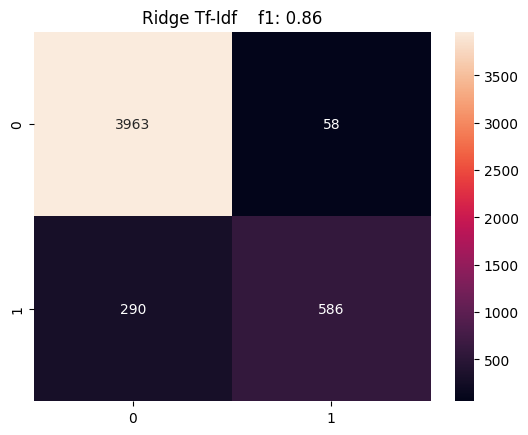

In [ ]:
print_confusion_matrix(y_test, y_pred, "Ridge Tf-Idf")

##### Ridge with CBOW

In [ ]:
rc_cbow = RidgeClassifier()
rc_cbow.fit(train_cbow_features, y_train)

RidgeClassifier()

In [ ]:
y_pred = rc_cbow.predict(test_cbow_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92      4021
           1       0.77      0.36      0.49       876

    accuracy                           0.87      4897
   macro avg       0.82      0.67      0.71      4897
weighted avg       0.86      0.87      0.85      4897



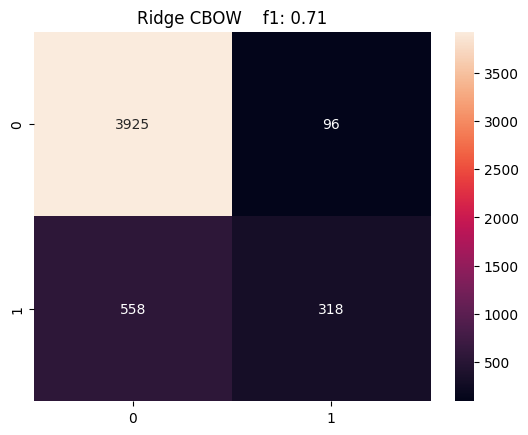

In [ ]:
print_confusion_matrix(y_test, y_pred, "Ridge CBOW")

##### RBF SVC with Tf-Idf

In [ ]:
svc_tfidf = SVC(kernel='rbf', C=1.1)
svc_tfidf.fit(train_tfidf_features, y_train)

SVC(C=1.1)

In [ ]:
y_pred = svc_tfidf.predict(test_tfidf_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      4021
           1       0.93      0.56      0.70       876

    accuracy                           0.91      4897
   macro avg       0.92      0.78      0.83      4897
weighted avg       0.92      0.91      0.91      4897



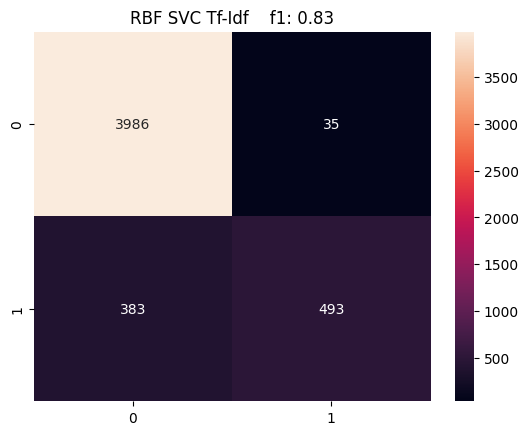

In [ ]:
print_confusion_matrix(y_test, y_pred, "RBF SVC Tf-Idf")

##### RBF SVC with CBOW

In [ ]:
svc_cbow = SVC(kernel='rbf', C=1.1)
svc_cbow.fit(train_cbow_features, y_train)

SVC(C=1.1)

In [ ]:
y_pred = svc_cbow.predict(test_cbow_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4021
           1       0.79      0.44      0.56       876

    accuracy                           0.88      4897
   macro avg       0.84      0.71      0.75      4897
weighted avg       0.87      0.88      0.86      4897



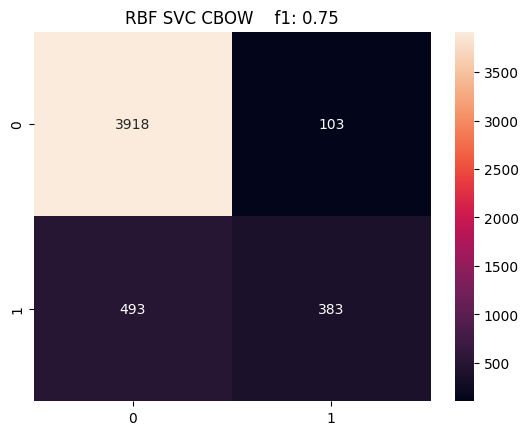

In [ ]:
print_confusion_matrix(y_test, y_pred, "RBF SVC CBOW")

##### Linear SVC with Tf-Idf

In [ ]:
lsvc_tfidf = LinearSVC(C=1.1)
lsvc_tfidf.fit(train_tfidf_features, y_train)

LinearSVC(C=1.1)

In [ ]:
y_pred = lsvc_tfidf.predict(test_tfidf_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4021
           1       0.89      0.71      0.79       876

    accuracy                           0.93      4897
   macro avg       0.91      0.85      0.88      4897
weighted avg       0.93      0.93      0.93      4897



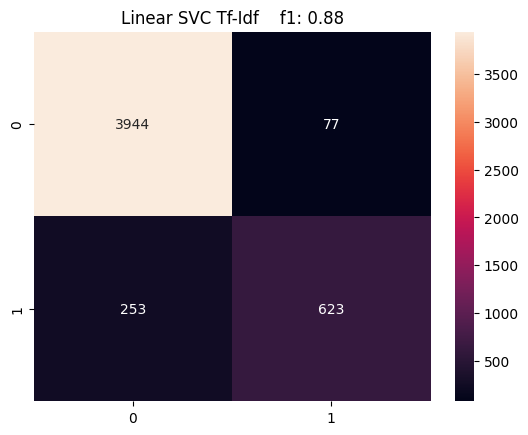

In [ ]:
print_confusion_matrix(y_test, y_pred, "Linear SVC Tf-Idf")

##### Linear SVC with CBOW

In [ ]:
lsvc_cbow = LinearSVC(max_iter=5000)
lsvc_cbow.fit(train_cbow_features, y_train)

C:\Users\Cristi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=5000)

In [ ]:
y_pred = lsvc_cbow.predict(test_cbow_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4021
           1       0.76      0.47      0.58       876

    accuracy                           0.88      4897
   macro avg       0.83      0.72      0.75      4897
weighted avg       0.87      0.88      0.87      4897



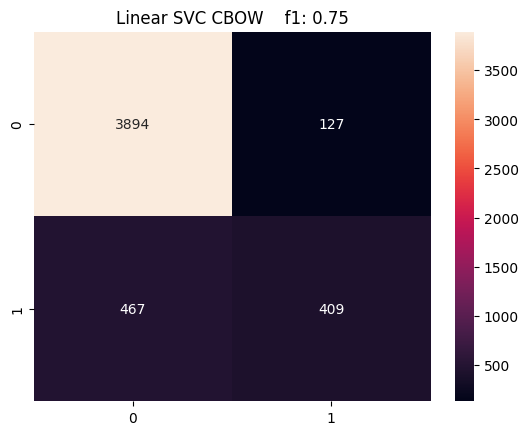

In [ ]:
print_confusion_matrix(y_test, y_pred, "Linear SVC CBOW")

##### Gradient Boosting with Tf-Idf

In [ ]:
gradient_tfidf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, subsample=0.75)
gradient_tfidf.fit(train_tfidf_features, y_train)

GradientBoostingClassifier(subsample=0.75)

In [ ]:
y_pred = gradient_tfidf.predict(test_tfidf_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4021
           1       0.87      0.51      0.64       876

    accuracy                           0.90      4897
   macro avg       0.88      0.74      0.79      4897
weighted avg       0.90      0.90      0.89      4897



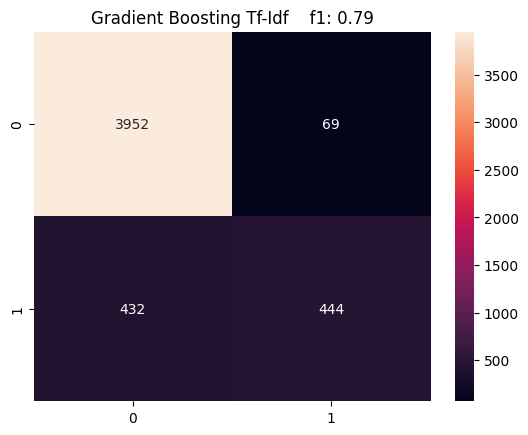

In [ ]:
print_confusion_matrix(y_test, y_pred, "Gradient Boosting Tf-Idf")

##### Gradient Boosting with CBOW

In [ ]:
gradient_cbow = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, subsample=0.75)
gradient_cbow.fit(train_cbow_features, y_train)

GradientBoostingClassifier(subsample=0.75)

In [ ]:
y_pred = gradient_cbow.predict(test_cbow_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4021
           1       0.76      0.47      0.58       876

    accuracy                           0.88      4897
   macro avg       0.83      0.72      0.76      4897
weighted avg       0.87      0.88      0.87      4897



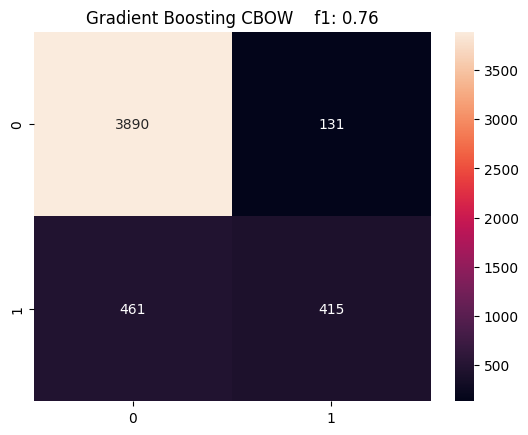

In [ ]:
print_confusion_matrix(y_test, y_pred, "Gradient Boosting CBOW")

##### Neural Network with Tf-Idf

In [ ]:
neural_tfidf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,), random_state=0, max_iter=500)
neural_tfidf.fit(train_tfidf_features, y_train)

MLPClassifier(alpha=1e-05, max_iter=500, random_state=0, solver='lbfgs')

In [ ]:
y_pred = neural_tfidf.predict(test_tfidf_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4021
           1       0.83      0.76      0.80       876

    accuracy                           0.93      4897
   macro avg       0.89      0.86      0.88      4897
weighted avg       0.93      0.93      0.93      4897



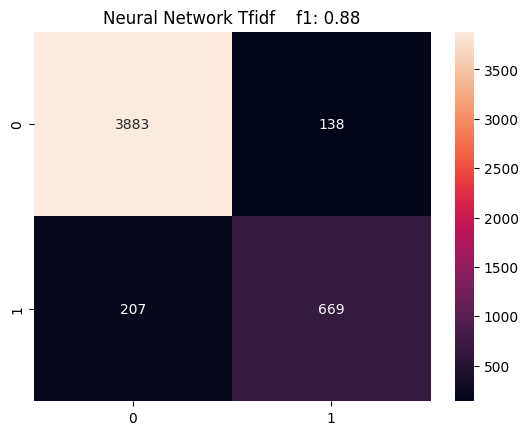

In [ ]:
print_confusion_matrix(y_test, y_pred, "Neural Network Tfidf")

##### Neural Network with CBOW

In [ ]:
neural_cbow = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,), random_state=0, max_iter=5000)
neural_cbow.fit(train_cbow_features, y_train)

MLPClassifier(alpha=1e-05, max_iter=5000, random_state=0, solver='lbfgs')

In [ ]:
y_pred = neural_cbow.predict(test_cbow_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4021
           1       0.57      0.60      0.58       876

    accuracy                           0.85      4897
   macro avg       0.74      0.75      0.75      4897
weighted avg       0.85      0.85      0.85      4897



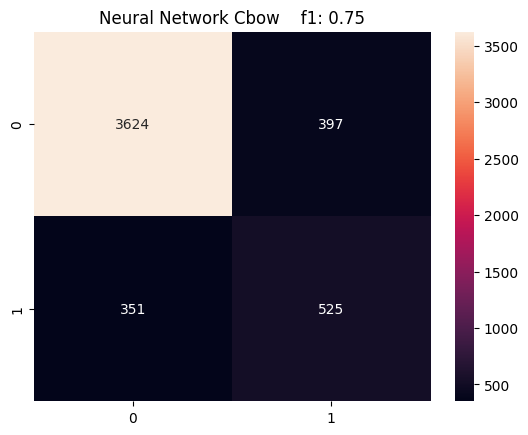

In [ ]:
print_confusion_matrix(y_test, y_pred, "Neural Network Cbow")

##### XGBoost with Tf-Idf

In [ ]:
xgboost = XGBClassifier(learning_rate=0.15, gamma=0.5, reg_alpha=0.5, max_depth=10, subsample=0.8, colsample_bytree=0.75, n_estimators=475)
xgboost.fit(train_tfidf_features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=475, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_pred = xgboost.predict(test_tfidf_features)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4021
           1       0.83      0.64      0.73       876

    accuracy                           0.91      4897
   macro avg       0.88      0.81      0.84      4897
weighted avg       0.91      0.91      0.91      4897



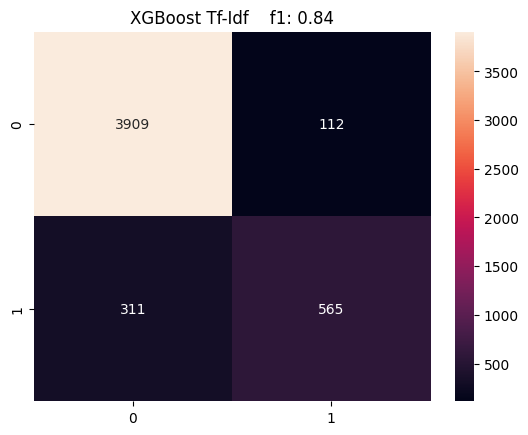

In [ ]:
print_confusion_matrix(y_test, y_pred, "XGBoost Tf-Idf")

##### Pre-trained Models - Model 1

In [ ]:
# source: https://huggingface.co/patrickquick/BERTicelli?text=Keep+up+the+good+hard+work.

tokenizer1 = AutoTokenizer.from_pretrained("patrickquick/BERTicelli")
model1 = AutoModelForSequenceClassification.from_pretrained("patrickquick/BERTicelli")
classifier1 = pipeline("text-classification", model=model1, tokenizer=tokenizer1)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
y_pred = [0 if classifier1(sentence)[0]['label'] == 'NOT' else 1 for sentence in dfTestTfidf['text']]

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      4021
           1       0.43      0.26      0.32       876

    accuracy                           0.80      4897
   macro avg       0.64      0.59      0.60      4897
weighted avg       0.78      0.80      0.79      4897



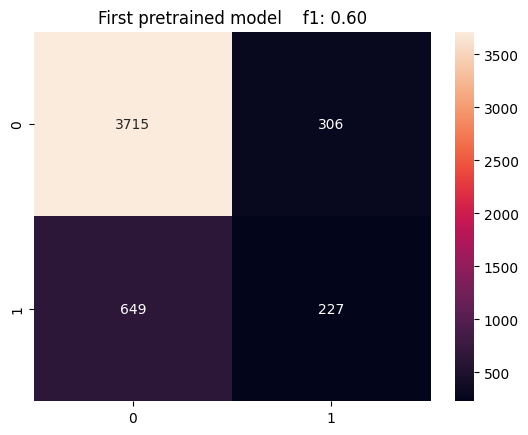

In [ ]:
print_confusion_matrix(y_test, y_pred, "First pretrained model")

##### Pre-trained Models - Model 2

In [ ]:
# source: https://huggingface.co/MilaNLProc/bert-base-uncased-ear-mlma

tokenizer2 = AutoTokenizer.from_pretrained("MilaNLProc/bert-base-uncased-ear-mlma")
model2 = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/bert-base-uncased-ear-mlma")
classifier2 = pipeline("text-classification", model=model2, tokenizer=tokenizer2)

In [ ]:
y_pred = [0 if classifier2(sentence)[0]['label'] == 'non-hateful' else 1 for sentence in dfTestTfidf['text']]

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      0.49      0.63      4021
           1       0.25      0.77      0.37       876

    accuracy                           0.54      4897
   macro avg       0.58      0.63      0.50      4897
weighted avg       0.79      0.54      0.59      4897



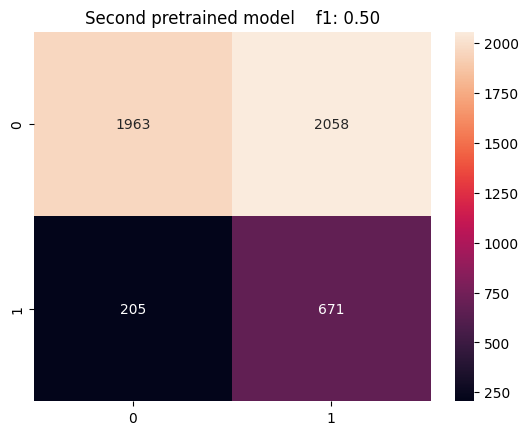

In [ ]:
print_confusion_matrix(y_test, y_pred, "Second pretrained model")

##### Pre-trained Models - Model 3

In [ ]:
# source: https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target

tokenizer3 = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
model3 = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
classifier3 = pipeline("text-classification", model=model3, tokenizer=tokenizer3)

In [ ]:
y_pred = [0 if classifier3(sentence)[0]['label'] == 'nothate' else 1 for sentence in dfTestTfidf['text']]

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4021
           1       0.53      0.19      0.28       876

    accuracy                           0.82      4897
   macro avg       0.69      0.58      0.59      4897
weighted avg       0.79      0.82      0.79      4897



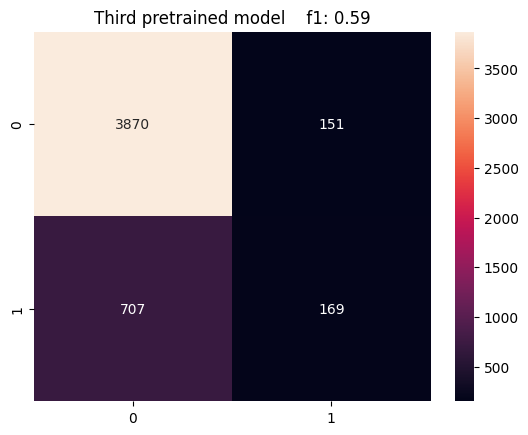

In [ ]:
print_confusion_matrix(y_test, y_pred, "Third pretrained model")

##### Pre-trained Models - Model 4

In [ ]:
# source: https://huggingface.co/Hate-speech-CNERG/bert-base-uncased-hatexplain

tokenizer4 = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")
model4 = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")
classifier4 = pipeline("text-classification", model=model4, tokenizer=tokenizer4)

In [ ]:
y_pred = [0 if classifier4(sentence)[0]['label'] == 'normal' else 1 for sentence in dfTestTfidf['text']]

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      4021
           1       0.51      0.07      0.13       876

    accuracy                           0.82      4897
   macro avg       0.67      0.53      0.51      4897
weighted avg       0.77      0.82      0.76      4897



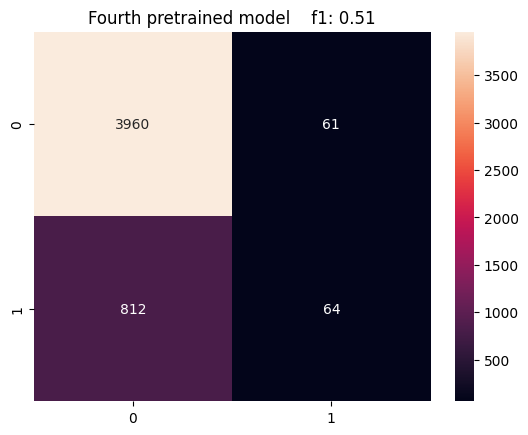

In [ ]:
print_confusion_matrix(y_test, y_pred, "Fourth pretrained model")

##### Pre-trained Models - Model 5

In [ ]:
# source: https://huggingface.co/Hate-speech-CNERG/dehatebert-mono-english

tokenizer5 = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
model5 = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
classifier5 = pipeline("text-classification", model=model5, tokenizer=tokenizer5)

In [ ]:
y_pred = [0 if classifier5(sentence)[0]['label'] == 'NON_HATE' else 1 for sentence in dfTestTfidf['text']]

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4021
           1       0.34      0.38      0.36       876

    accuracy                           0.76      4897
   macro avg       0.60      0.61      0.60      4897
weighted avg       0.77      0.76      0.76      4897



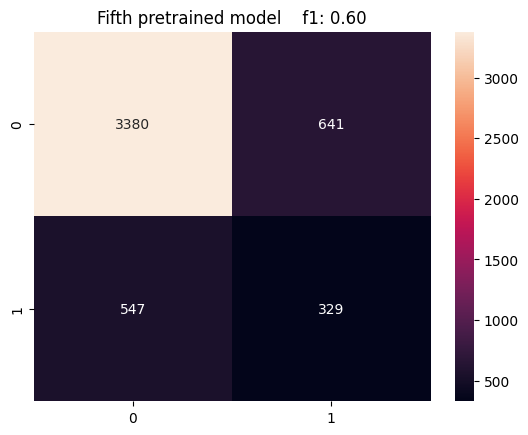

In [ ]:
print_confusion_matrix(y_test, y_pred, "Fifth pretrained model")

#### Deep Neural Network

In [17]:
train_tokens = dfTrainTfidf['tokens']

# Create the Word2Vec model
model = Word2Vec(vector_size=300, window=2, min_count=3, workers=8, sg=1)

# # Build the vocabulary
model.build_vocab(train_tokens)
# # Train the Word2Vec model

model.train(train_tokens, total_examples=model.corpus_count, epochs=40)

(1604141, 2219680)

In [18]:
def preprocess(review):
  representation = np.zeros(300)
  n_words = 0
  for word in review:
    try:
      representation += model.wv[word]
      n_words += 1
    except:
      pass

  if n_words == 0:
    return representation

  return representation / n_words

In [19]:
train_data = np.array([preprocess(dfTrainTfidf.iloc[[i]]['tokens'].tolist()[0]) for i in range(dfTrainTfidf['clean'].size)]).astype(np.float32)
test_data = np.array([preprocess(dfTestTfidf.iloc[[i]]['tokens'].tolist()[0]) for i in range(dfTestTfidf['clean'].size)]).astype(np.float32)

In [20]:
train_labels = dfTrainTfidf['label']
test_labels = dfTestTfidf['label']

train_data

array([[ 0.03554851,  0.11020362, -0.16466494, ..., -0.01596248,
         0.05704811, -0.07131825],
       [ 0.16517177,  0.30150044, -0.10461496, ..., -0.21422446,
         0.20748197, -0.04605553],
       [ 0.25397325,  0.7202316 , -0.1100354 , ...,  0.10054438,
         0.4851569 , -0.33719912],
       ...,
       [-0.07748929,  0.1278313 , -0.01226687, ..., -0.08221125,
         0.19878839, -0.08265412],
       [ 0.01643744,  0.1603624 ,  0.31535715, ...,  0.07135399,
         0.13923661, -0.08384418],
       [ 0.02329691,  0.10331074, -0.05535306, ..., -0.1761028 ,
         0.18525982, -0.02104861]], dtype=float32)

In [21]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(300, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2)
        )
    
    def forward(self, input):
        return self.layer(input)

In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, split):
        super().__init__()
        
        if split == 'train':
            self.data = train_data
            self.labels = train_labels
        else:
            self.data = test_data
            self.labels = test_labels
        
    def __getitem__(self, sample_n):
        return self.data[sample_n], self.labels[sample_n]
    
    def __len__(self):
        return len(self.labels)

In [23]:
model = Model()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

batch_size = 256
train_dataset = Dataset(split = 'train')
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle = True,
    batch_size = batch_size,
    num_workers = 10,
)
val_dataset = Dataset(split = 'test')
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = batch_size,
    num_workers = 10,
)

predictions = []
best_acc = 0

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
for epoch_n in tqdm(range(100)):
    model.train()
    for batch in train_dataloader:
        input, target = batch
        input = input
        target = target
        
        optimizer.zero_grad()

        output = model(input)
        loss = loss_function(output, target)

        loss.backward()
        optimizer.step()
        
    model.eval()
    current_predictions = []
    val_acc = []

    for batch in val_dataloader:
        input, target = batch
        input = input
        target = target
        
        with torch.no_grad():
            output = model(input)
            current_predictions.extend(output.argmax(1))
        
        val_acc += (output.argmax(1) == target).tolist()
    
    acc = np.mean(val_acc)
    if(acc > best_acc):
      torch.save(model.state_dict(), "sample_data/best_model.pt")
      best_acc = acc
      predictions = current_predictions

    print(acc)

  1%|          | 1/100 [00:02<03:58,  2.41s/it]

0.8787012456606086


  2%|▏         | 2/100 [00:04<03:15,  1.99s/it]

0.8889115785174597


  3%|▎         | 3/100 [00:05<02:55,  1.80s/it]

0.8852358586889932


  4%|▍         | 4/100 [00:07<02:44,  1.71s/it]

0.8968756381458035


  5%|▌         | 5/100 [00:08<02:39,  1.68s/it]

0.8981008780886257


  6%|▌         | 6/100 [00:10<02:33,  1.64s/it]

0.8962630181743925


  7%|▋         | 7/100 [00:12<02:32,  1.64s/it]

0.8991219113743109


  8%|▊         | 8/100 [00:14<02:55,  1.90s/it]

0.9021850112313662


  9%|▉         | 9/100 [00:16<03:05,  2.04s/it]

0.9054523177455585


 10%|█         | 10/100 [00:18<02:52,  1.91s/it]

0.9068817643455177


 11%|█         | 11/100 [00:20<02:40,  1.81s/it]

0.9064733510312436


 12%|█▏        | 12/100 [00:21<02:32,  1.73s/it]

0.9064733510312436


 13%|█▎        | 13/100 [00:23<02:27,  1.69s/it]

0.9062691443741066


 14%|█▍        | 14/100 [00:24<02:22,  1.65s/it]

0.8983050847457628


 15%|█▌        | 15/100 [00:26<02:19,  1.64s/it]

0.9083112109454768


 16%|█▌        | 16/100 [00:28<02:34,  1.84s/it]

0.9070859710026546


 17%|█▋        | 17/100 [00:31<02:47,  2.02s/it]

0.9042270778027364


 18%|█▊        | 18/100 [00:32<02:40,  1.96s/it]

0.9058607310598326


 19%|█▉        | 19/100 [00:34<02:31,  1.87s/it]

0.8970798448029406


 20%|██        | 20/100 [00:36<02:24,  1.81s/it]

0.9017765979170921


 21%|██        | 21/100 [00:37<02:18,  1.75s/it]

0.9046354911170104


 22%|██▏       | 22/100 [00:39<02:12,  1.70s/it]

0.9052481110884215


 23%|██▎       | 23/100 [00:41<02:09,  1.69s/it]

0.9038186644884624


 24%|██▍       | 24/100 [00:44<02:46,  2.19s/it]

0.9040228711455993


 25%|██▌       | 25/100 [00:46<02:48,  2.24s/it]

0.8891157851745967


 26%|██▌       | 26/100 [00:48<02:35,  2.10s/it]

0.8895241984888708


 27%|██▋       | 27/100 [00:50<02:24,  1.98s/it]

0.9027976312027772


 28%|██▊       | 28/100 [00:52<02:18,  1.93s/it]

0.8962630181743925


 29%|██▉       | 29/100 [00:53<02:11,  1.86s/it]

0.9048396977741474


 30%|███       | 30/100 [00:55<02:06,  1.81s/it]

0.9017765979170921


 31%|███       | 31/100 [00:57<02:13,  1.94s/it]

0.8976924647743516


 32%|███▏      | 32/100 [01:00<02:29,  2.20s/it]

0.8989177047171738


 33%|███▎      | 33/100 [01:02<02:24,  2.15s/it]

0.9025934245456402


 34%|███▍      | 34/100 [01:04<02:14,  2.04s/it]

0.8985092914028997


 35%|███▌      | 35/100 [01:06<02:06,  1.94s/it]

0.9046354911170104


 36%|███▌      | 36/100 [01:07<01:59,  1.87s/it]

0.9076985909740658


 37%|███▋      | 37/100 [01:09<01:54,  1.83s/it]

0.9056565244026955


 38%|███▊      | 38/100 [01:11<01:51,  1.79s/it]

0.9060649377169696


 39%|███▉      | 39/100 [01:13<02:05,  2.06s/it]

0.8940167449458852


 40%|████      | 40/100 [01:16<02:12,  2.20s/it]

0.9001429446599959


 41%|████      | 41/100 [01:18<02:01,  2.07s/it]

0.9056565244026955


 42%|████▏     | 42/100 [01:19<01:53,  1.96s/it]

0.8997345313457219


 43%|████▎     | 43/100 [01:21<01:46,  1.88s/it]

0.9054523177455585


 44%|████▍     | 44/100 [01:23<01:42,  1.83s/it]

0.8999387380028588


 45%|████▌     | 45/100 [01:25<01:38,  1.80s/it]

0.901572391259955


 46%|████▌     | 46/100 [01:27<01:40,  1.85s/it]

0.9050439044312845


 47%|████▋     | 47/100 [01:29<01:50,  2.08s/it]

0.9038186644884624


 48%|████▊     | 48/100 [01:31<01:51,  2.14s/it]

0.9058607310598326


 49%|████▉     | 49/100 [01:33<01:42,  2.02s/it]

0.9036144578313253


 50%|█████     | 50/100 [01:35<01:35,  1.92s/it]

0.9017765979170921


 51%|█████     | 51/100 [01:37<01:31,  1.86s/it]

0.9046354911170104


 52%|█████▏    | 52/100 [01:38<01:27,  1.81s/it]

0.9034102511741883


 53%|█████▎    | 53/100 [01:40<01:24,  1.79s/it]

0.900959771288544


 54%|█████▍    | 54/100 [01:42<01:29,  1.95s/it]

0.9050439044312845


 55%|█████▌    | 55/100 [01:45<01:37,  2.17s/it]

0.8970798448029406


 56%|█████▌    | 56/100 [01:47<01:32,  2.10s/it]

0.9036144578313253


 57%|█████▋    | 57/100 [01:49<01:25,  1.99s/it]

0.9074943843169287


 58%|█████▊    | 58/100 [01:50<01:20,  1.91s/it]

0.9046354911170104


 59%|█████▉    | 59/100 [01:52<01:16,  1.85s/it]

0.9046354911170104


 60%|██████    | 60/100 [01:54<01:12,  1.82s/it]

0.901572391259955


 61%|██████    | 61/100 [01:56<01:10,  1.81s/it]

0.8970798448029406


 62%|██████▏   | 62/100 [01:58<01:19,  2.09s/it]

0.9060649377169696


 63%|██████▎   | 63/100 [02:01<01:21,  2.20s/it]

0.9062691443741066


 64%|██████▍   | 64/100 [02:03<01:14,  2.08s/it]

0.8940167449458852


 65%|██████▌   | 65/100 [02:05<01:10,  2.02s/it]

0.8960588115172554


 66%|██████▌   | 66/100 [02:06<01:06,  1.94s/it]

0.9021850112313662


 67%|██████▋   | 67/100 [02:08<01:01,  1.87s/it]

0.9023892178885031


 68%|██████▊   | 68/100 [02:10<00:59,  1.85s/it]

0.9032060445170512


 69%|██████▉   | 69/100 [02:12<01:02,  2.02s/it]

0.8997345313457219


 70%|███████   | 70/100 [02:15<01:06,  2.23s/it]

0.8995303246885848


 71%|███████   | 71/100 [02:17<01:01,  2.13s/it]

0.8925872983459261


 72%|███████▏  | 72/100 [02:19<00:56,  2.02s/it]

0.8972840514600776


 73%|███████▎  | 73/100 [02:20<00:52,  1.96s/it]

0.8927915050030631


 74%|███████▍  | 74/100 [02:22<00:49,  1.92s/it]

0.9034102511741883


 75%|███████▌  | 75/100 [02:24<00:47,  1.90s/it]

0.9056565244026955


 76%|███████▌  | 76/100 [02:26<00:47,  1.98s/it]

0.8938125382887482


 77%|███████▋  | 77/100 [02:29<00:51,  2.24s/it]

0.8989177047171738


 78%|███████▊  | 78/100 [02:31<00:48,  2.22s/it]

0.8995303246885848


 79%|███████▉  | 79/100 [02:33<00:43,  2.09s/it]

0.9046354911170104


 80%|████████  | 80/100 [02:35<00:40,  2.04s/it]

0.9030018378599143


 81%|████████  | 81/100 [02:37<00:37,  1.98s/it]

0.8991219113743109


 82%|████████▏ | 82/100 [02:39<00:34,  1.94s/it]

0.8991219113743109


 83%|████████▎ | 83/100 [02:41<00:33,  1.98s/it]

0.9017765979170921


 84%|████████▍ | 84/100 [02:44<00:36,  2.28s/it]

0.9030018378599143


 85%|████████▌ | 85/100 [02:46<00:34,  2.29s/it]

0.9025934245456402


 86%|████████▌ | 86/100 [02:48<00:30,  2.16s/it]

0.8985092914028997


 87%|████████▋ | 87/100 [02:50<00:26,  2.07s/it]

0.90055135797427


 88%|████████▊ | 88/100 [02:52<00:24,  2.03s/it]

0.8999387380028588


 89%|████████▉ | 89/100 [02:54<00:21,  1.98s/it]

0.8950377782315704


 90%|█████████ | 90/100 [02:56<00:19,  1.98s/it]

0.8962630181743925


 91%|█████████ | 91/100 [02:59<00:22,  2.55s/it]

0.9030018378599143


 92%|█████████▏| 92/100 [03:02<00:19,  2.43s/it]

0.9060649377169696


 93%|█████████▎| 93/100 [03:04<00:16,  2.30s/it]

0.9034102511741883


 94%|█████████▍| 94/100 [03:06<00:13,  2.23s/it]

0.900959771288544


 95%|█████████▌| 95/100 [03:08<00:10,  2.14s/it]

0.9036144578313253


 96%|█████████▌| 96/100 [03:10<00:08,  2.07s/it]

0.9019808045742291


 97%|█████████▋| 97/100 [03:12<00:06,  2.28s/it]

0.9003471513171329


 98%|█████████▊| 98/100 [03:15<00:04,  2.45s/it]

0.8978966714314887


 99%|█████████▉| 99/100 [03:17<00:02,  2.29s/it]

0.9034102511741883


100%|██████████| 100/100 [03:19<00:00,  1.99s/it]

0.9034102511741883


In [25]:
model.load_state_dict(torch.load("sample_data/best_model.pt"))

<All keys matched successfully>

In [26]:
predictions = []

for batch in val_dataloader:
        input, target = batch
        input = input
        target = target
        
        with torch.no_grad():
            output = model(input)
            predictions.extend(output.argmax(1))

predictions = [int(x) for x in predictions]
print(predictions)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
print(classification_report(y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      4021
           1       0.81      0.64      0.71       876

    accuracy                           0.91      4897
   macro avg       0.87      0.80      0.83      4897
weighted avg       0.90      0.91      0.90      4897



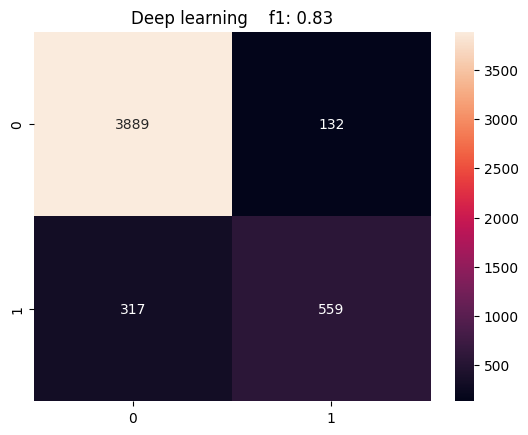

In [30]:
print_confusion_matrix(y_test, predictions, "Deep learning")